In [9]:
from __future__ import print_function                                                                                                                                
from imp import reload
import sys
import os
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as LA
import scipy.sparse as sp
from copy import deepcopy
import modules.axial_approximation.axial_kane_model as akm
import modules.axial_approximation.axial_wurtzite_model as awm
from modules.axial_approximation.solver import solve_cylindrical
from modules.convert_parameters import angstrom_par
from modules.parameters import constants
import sympy
from IPython.display import display, Math, Latex
sympy.init_printing()

# Hamiltonian in axial approximation

In [2]:
awm.H_polar

# Infinite wire with hard boundaries

In [3]:
## wire parameters                                                                                                                                                   
diameter = 800  # in Angstrom
Nd       = 401  # radial discretization steps
kz       = 0.   # momentum along wire
B        = 1e-6 # just for measuring g-factors
Fz_max   = 5/2 
Fz_list  = np.linspace(-Fz_max,Fz_max,2*Fz_max+1) # list of angular momenta sectors to solve
n = 8           # how many energies to keep in each sector 
par = awm.InAs_wurtzite_par  # k.p parameters
par

In [4]:
## solve wire
E_list = [] # energies
V_list = [] # states
S_list = [] # spin expectation values of s-orbital (for g-factor)
density_list = []
for fz in Fz_list:
    print(fz)
    E, V = solve_cylindrical(awm.H_dict,awm.J,diameter,Nd,fz,kz,B,par=par,nsparse=40,solverargs={'sigma':0})
    log = E > 0 # only take energies in conduction band starting at E=0
    E = E[log]
    V = V[:,log]
    E = E[:n]
    V = V[:,:n]

    assert np.isclose(E.imag,0).all()

    density = np.abs(V.T)**2
    for i in range(1,8):
        density[:,:Nd] += density[:,i*Nd:(i+1)*Nd]
    density = density[:,:Nd]
    
    S_list.append([
            2*(LA.norm(v[:Nd])/LA.norm(v)-0.5) for v in V.T
        ])

    E_list.append(E)
    V_list.append(V)
    density_list.append(density)

-2.5
-1.5
-0.5
0.5
1.5
2.5


In [5]:
## show energy levels
cs1 = ['b','g','r','r','g','b']
cs2 = ['.','.','.','x','x','x']

ind1 = np.argsort(np.array(E_list).flatten().real)
ind2 = [(i//n,i%n) for i in ind1]

E = np.array([E_list[i][j] for i,j in ind2]).real
cs = [cs1[i]+cs2[i] for i,j in ind2]                                                                                                                                 
V = np.array([V_list[i][:,j] for i,j in ind2])
S = np.array([S_list[i][j] for i,j in ind2])
density = np.array([density_list[i][j] for i,j in ind2])

gfactors = np.sign(np.diff(S)[:12:2])*np.diff(E)[:12:2]/LA.norm(B)/5.788382e-5                                                                                                                 

display(Math('g = '+', '.join('{:0.2f}'.format(gi) for gi in gfactors)))
display(Latex('$\Delta E_1 = {:0.2f}\,$meV'.format((E_list[1][0]-E_list[2][1]).real*1e3)))
display(Latex('$\Delta E_2 = {:0.2f}\,$meV'.format((E_list[0][0]-E_list[1][1]).real*1e3)))

plt.figure()
for i,e in enumerate(E[:12]):
    plt.plot(i,1e3*e,cs[i])
plt.ylabel(r'$E_n\,(\mathrm{meV})$')
plt.xlabel(r'n')
plt.show()

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [6]:
## Norm squared wave functions
rho = np.linspace(0,diameter/2,Nd)
fig, axes = plt.subplots(figsize=(8,8),nrows=3,ncols=2, sharey=True,sharex=True)
for i in range(0,12,2):                                                                                                                                      
    ax = axes[i//4,(i//2)%2]
    ax.set_title(r"$E = {0:0.2f}\,meV, |F_z| = {1:0.1f}, g = {2:0.2f}$".format(1e3*E[i],abs(Fz_list[ind2[i][0]]),gfactors[i//2]))
    ax.plot(rho,density[i],label='Fz = '+str(Fz_list[ind2[i][0]]))
for ax in axes[-1,:]:
    ax.set_xlabel(r'$r\,(\mathrm{\AA})$')
for ax in axes[:,0]:
    ax.set_ylabel(r'$|\psi(r)|^2$')
plt.show()

# Diameter dependence

In [7]:
diameter_list = 100*2**(np.arange(0,28)/4)
Nd       = 801
kz       = 0.
B        = 0.0
Fz_list  = [1/2,3/2,5/2]
n = 4

In [8]:
E_list = [[] for _ in diameter_list]
V_list = [[] for _ in diameter_list]
density_list = [[] for _ in diameter_list]
for nd, diameter in enumerate(diameter_list):
    print(diameter)
    for fz in Fz_list:
        print(fz)
        E, V = solve_cylindrical(awm.H_dict,awm.J,diameter,Nd,fz,kz,B,par=par,nsparse=80,solverargs={'sigma':0})
        log = E > 0
        E = E[log]
        V = V[:,log]
        E = E[:n]
        V = V[:,:n]

        assert np.isclose(E.imag,0).all()

        density = np.abs(V.T)**2
        for i in range(1,8):
            density[:,:Nd] += density[:,i*Nd:(i+1)*Nd]
        density = density[:,:Nd]

        E_list[nd].append(E)
        V_list[nd].append(V)
        density_list[nd].append(density)

E = np.array(E_list).real

100.0
0.5
1.5
2.5
118.9207115
0.5
1.5
2.5
141.421356237
0.5
1.5
2.5
168.179283051
0.5
1.5
2.5
200.0
0.5
1.5
2.5
237.841423001
0.5
1.5
2.5
282.842712475
0.5
1.5
2.5
336.358566101
0.5
1.5
2.5
400.0
0.5
1.5
2.5
475.682846001
0.5
1.5
2.5
565.685424949
0.5
1.5
2.5
672.717132203
0.5
1.5
2.5
800.0
0.5
1.5
2.5
951.365692002
0.5
1.5
2.5
1131.3708499
0.5
1.5
2.5
1345.43426441
0.5
1.5
2.5
1600.0
0.5
1.5
2.5
1902.731384
0.5
1.5
2.5
2262.7416998
0.5
1.5
2.5
2690.86852881
0.5
1.5
2.5
3200.0
0.5
1.5
2.5
3805.46276801
0.5
1.5
2.5
4525.48339959
0.5
1.5
2.5
5381.73705762
0.5
1.5
2.5
6400.0
0.5
1.5
2.5
7610.92553602
0.5
1.5
2.5
9050.96679919
0.5
1.5
2.5
10763.4741152
0.5
1.5
2.5


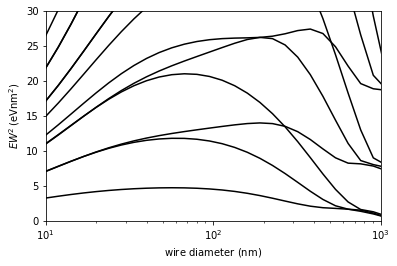

In [22]:
W = np.array(diameter_list)/10

plt.figure(figsize=(6,4))
plt.subplots_adjust(bottom=0.15)
plt.semilogx(W,1e3*(E[:,1,0]-E[:,0,1]),'k.-',label=r"$L_z=1:\ E_{F_z=\frac{3}{2}}-E_{F_z=\frac{1}{2}}$")
plt.semilogx(W,1e3*(E[:,2,0]-E[:,1,1]),'k.--',label=r"$L_z=2:\ E_{F_z=\frac{5}{2}}-E_{F_z=\frac{3}{2}}$")
plt.xlabel('$\mathrm{wire\ diameter}\ (\mathrm{nm})$')
plt.ylabel('$\Delta E\ (\mathrm{meV})$')
plt.legend(loc="upper right") 
plt.xlim([10,1000])
plt.show()

m = 0.0416*constants['m_0']
alpha = 0.03
eshift = m*alpha**2/(2*constants['hbar']**2)
offset = LA.eigvalsh(np.array(awm.H_cartesian.subs(awm.InAs_wurtzite_par).subs(dict(k_x=0,k_y=0,k_z=0)).tolist(),dtype=complex))[6]-eshift

plt.figure(figsize=(6,4))
plt.subplots_adjust(bottom=0.15)
for i, _ in enumerate(Fz_list):
    for j in range(n):
        plt.semilogx(W, (E[:,i,j]-offset)*W**2/4,'k')
plt.ylim([0,30])
plt.xlim([10,1000])
plt.xlabel('$\mathrm{wire\ diameter}\ (\mathrm{nm})$')
plt.ylabel('$E W^2\,(\mathrm{eV nm}^2)$')        
plt.show()